In [36]:
# Enable matplotlib interactive mode
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from ema_workbench import (Model, MultiprocessingEvaluator, Policy, Scenario)
# #running the model through EMA workbench
# from ema_workbench import (MultiprocessingEvaluator, ema_logging,
#                        perform_experiments, SequentialEvaluator)

from ema_workbench.em_framework.evaluators import perform_experiments
from ema_workbench.em_framework.samplers import sample_uncertainties
from ema_workbench.util import ema_logging
from problem_formulation import get_model_for_problem_formulation
import copy
from ema_workbench import load_results
from ema_workbench.analysis import prim
from ema_workbench.analysis import dimensional_stacking

ema_logging.log_to_stderr(ema_logging.INFO)

<Logger EMA (DEBUG)>

## define function for PRIM

In [37]:
def find_PRIM(x, outcomes, outcome_name, quantile = 0.95, threshold = 0.5, return_y = False):
    plt.figure(figsize=(15, 15))
    if type(outcome_name) == list:
        #create list of zeros to later apply filtering condition
        y = np.array([0] * len(x.index))
        
        
        #loop over the different outcomes we are interested in
        for outcome in outcome_name:    
            
            #select the y values
            y_all = outcomes[outcome]
            
            #find the limit value of the quantile
            y_limit = np.quantile(y_all, quantile)   
            
            #apply filtering condition resuling in a boolean array
            y_filtered = np.array([value > y_limit for value in y_all])

            #sum up the arrays. the number in this array shows for how many quantiles a scenario was above the limit
            y += y_filtered
        
        #if the amount of times the quantile condition was met is equal to the outcomes then a 1 is retured
        y = np.array([1 if n == len(outcome_name) else 0 for n in y])
        
    else:  
        # Set our output threshold to be a percentile of all of those outputs
        y_all = outcomes[outcome_name]
        
        # Set our output threshold to be a percentile of all of those outputs
        y_limit = np.quantile(y_all, quantile)

        # # Only select outputs that are above this threshold
        y = np.array([value > y_limit for value in y_all])

        

    # Conduct our prim analysis using a threshold of 0.8
    prim_object = prim.Prim(x, y, threshold= threshold)

    #get the PRIM BOX
    prim_box = prim_object.find_box()

    #visualize the box tradeoff
    prim_box.show_tradeoff(annotated=True)
    
    plt.show()

    if return_y == True:
        return prim_object, prim_box, y
    
    else:
        return prim_object, prim_box

# Run the model

In [38]:
problem_formulation = 1
scenarios = 4000

#import the model with the specific problem formulation
dike_model, planning_steps = get_model_for_problem_formulation(problem_formulation)

# Set uncertainties and levers variables
uncertainties = copy.deepcopy(dike_model.uncertainties)
levers = copy.deepcopy(dike_model.levers)

def get_do_nothing_dict():
    return {l.name: 0 for l in dike_model.levers}


policies = [
    Policy(
        "policy 1",
        **dict(
            get_do_nothing_dict(),
            **{"0_RfR 0": 0, "0_RfR 1": 0, "0_RfR 2": 0, "A.1_DikeIncrease 0": 0}
        )
    )
]

# ema_logging.log_to_stderr(ema_logging.INFO)

# Make use of the multiprocessing evaluator to save time
# running with X scenarios
with MultiprocessingEvaluator(dike_model, n_processes=7) as evaluator:
    results = evaluator.perform_experiments(scenarios=scenarios, policies=policies)

# Save results for later analysis
from ema_workbench import save_results
file_name = f'{scenarios}  base scenarios policy pf {problem_formulation}.tar.gz'
save_results(results, 'results/' + file_name)

[MainProcess/INFO] pool started with 7 workers
[MainProcess/INFO] performing 4000 scenarios * 1 policies * 1 model(s) = 4000 experiments
100%|██████████████████████████████████████| 4000/4000 [17:02<00:00,  3.91it/s]
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool
[MainProcess/INFO] results saved successfully to C:\Users\Shahram\PyCharm\final assignment_MBDM2_Frenk\final assignment\results\4000  base scenarios policy pf 1.tar.gz


# Scenario Discovery


## whole Ijsel area

### run the model PF2

### load pf 1


In [39]:
# Load results that were previously generated
load_file_name ='results/4000  base scenarios policy pf 1.tar.gz'
experiments, outcomes = load_results(load_file_name)

[MainProcess/INFO] results loaded successfully from C:\Users\Shahram\PyCharm\final assignment_MBDM2_Frenk\final assignment\results\4000  base scenarios policy pf 1.tar.gz


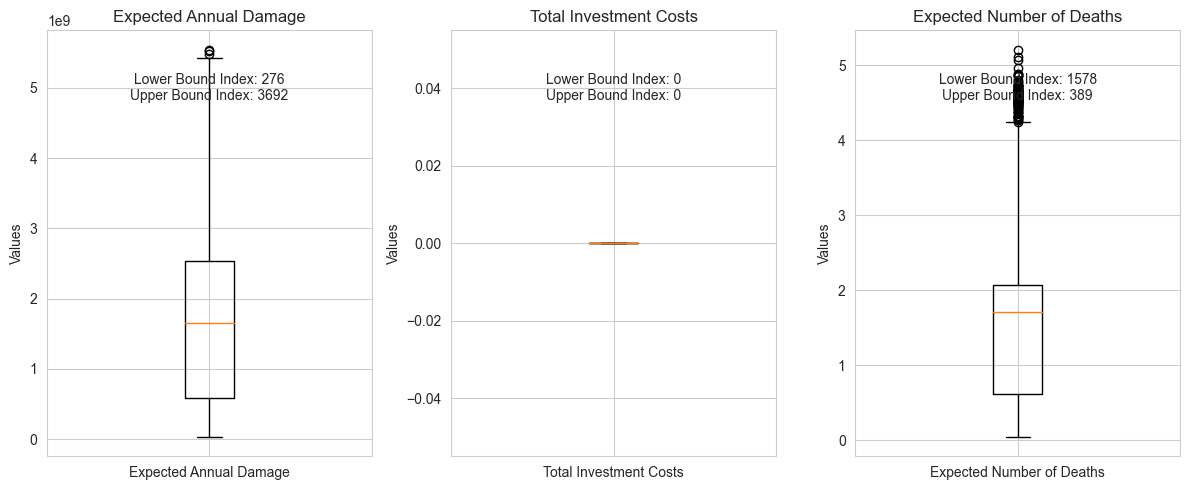

In [40]:
# Create a figure and subplots with 1 row and 3 columns
fig, axs = plt.subplots(1, 3, figsize=(12, 5))

# Iterate over the dictionary and create a boxplot for each key-value pair
for i, (key, values) in enumerate(outcomes.items()):
    # Create a boxplot on the corresponding axis
    axs[i].boxplot(values)
    
    # Calculate the upper and lower bounds
    lower_bound = np.min(values)
    upper_bound = np.max(values)
    
    # Find the index of the upper and lower bounds
    lower_index = np.argmin(values)
    upper_index = np.argmax(values)
    
    # Set labels and title for the subplot
    axs[i].set_xticklabels([key])
    axs[i].set_ylabel('Values')
    axs[i].set_title(key)
    
    # Display the index of the upper and lower bounds
    axs[i].text(0.5, 0.9, f"Lower Bound Index: {lower_index}\nUpper Bound Index: {upper_index}", 
                transform=axs[i].transAxes, ha='center', va='top')

# Adjust the spacing between subplots
plt.tight_layout()

# Display the plot
plt.show()

In [41]:
relevant_scenarios = experiments.iloc[[826,1103,1502,2253],:]

# export relevant scenarios
relevant_scenarios.to_csv('results/relevant scenarios.csv', index=False)

## inspect data

In [42]:
print(outcomes.keys())
display(experiments)

dict_keys(['Expected Annual Damage', 'Total Investment Costs', 'Expected Number of Deaths'])


A.0_ID flood wave shape    A.1_Bmax  A.1_Brate  A.1_pfail    A.2_Bmax   
0                         111  199.729064       10.0   0.728315  333.926205  \
1                          50  270.743102       10.0   0.105665  309.716567   
2                          23  294.210722       10.0   0.192426   90.241216   
3                         113  278.227093        1.0   0.695828  171.045448   
4                          26  199.834561        1.0   0.419797  107.977935   
...                       ...         ...        ...        ...         ...   
3995                      109  117.813231        1.0   0.976931  226.280979   
3996                       18  170.562129        1.5   0.064562  107.899890   
3997                       72  268.357214       10.0   0.869232  234.366577   
3998                       19  201.022556        1.0   0.441047  169.360077   
3999                        8  315.069437       10.0   0.341112  174.111987   

      A.2_Brate  A.2_pfail    A.3_Bmax  A.3_Brate  A.3_pfail  ...   
0           1.0   0.331850   45.621512        1.5   0.372195  ...  \
1           1.5   0.943325  220.297507        1.0   0.287723  ...   
2          10.0   0.406331  252.585189        1.0   0.719705  ...   
3           1.5   0.098800  163.243018        1.5   0.315571  ...   
4          10.0   0.861094  215.968198        1.0   0.620621  ...   
...         ...        ...         ...        ...        ...  ...   
3995        1.5   0.792938  219.937644        1.5   0.712525  ...   
3996        1.5   0.537565  213.083059        1.5   0.964817  ...   
3997       10.0   0.408936  335.376328        1.5   0.056168  ...   
3998        1.0   0.864249  202.717437        1.0   0.889174  ...   
3999        1.5   0.101591  322.377240        1.5   0.010197  ...   

      A.3_DikeIncrease 2  A.4_DikeIncrease 0  A.4_DikeIncrease 1   
0                      0                   0                   0  \
1                      0                   0                   0   
2                      0                   0                   0   
3                      0                   0                   0   
4                      0                   0                   0   
...                  ...                 ...                 ...   
3995                   0                   0                   0   
3996                   0                   0                   0   
3997                   0                   0                   0   
3998                   0                   0                   0   
3999                   0                   0                   0   

      A.4_DikeIncrease 2  A.5_DikeIncrease 0  A.5_DikeIncrease 1   
0                      0                   0                   0  \
1                      0                   0                   0   
2                      0                   0                   0   
3                      0                   0                   0   
4                      0                   0                   0   
...                  ...                 ...                 ...   
3995                   0                   0                   0   
3996                   0                   0                   0   
3997                   0                   0                   0   
3998                   0                   0                   0   
3999                   0                   0                   0   

      A.5_DikeIncrease 2  scenario    policy     model  
0                      0      4000  policy 1  dikesnet  
1                      0      4001  policy 1  dikesnet  
2                      0      4002  policy 1  dikesnet  
3                      0      4003  policy 1  dikesnet  
4                      0      4004  policy 1  dikesnet  
...                  ...       ...       ...       ...  
3995                   0      7995  policy 1  dikesnet  
3996                   0      7996  policy 1  dikesnet  
3997                   0      7997  policy 1  dikesnet  
3998                   0

## look into annual damage

### PRIM

[MainProcess/INFO] 4000 points remaining, containing 800 cases of interest
[MainProcess/INFO] mean: 0.9910714285714286, mass: 0.056, coverage: 0.2775, density: 0.9910714285714286 restricted_dimensions: 7


<Figure size 1500x1500 with 0 Axes>

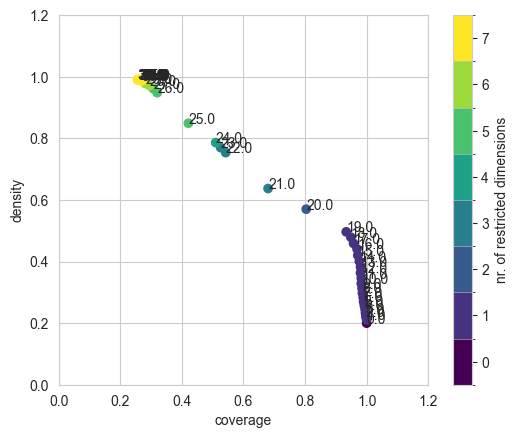

[MainProcess/INFO] 4000 points remaining, containing 800 cases of interest
[MainProcess/INFO] mean: 1.0, mass: 0.088, coverage: 0.44, density: 1.0 restricted_dimensions: 4


<Figure size 1500x1500 with 0 Axes>

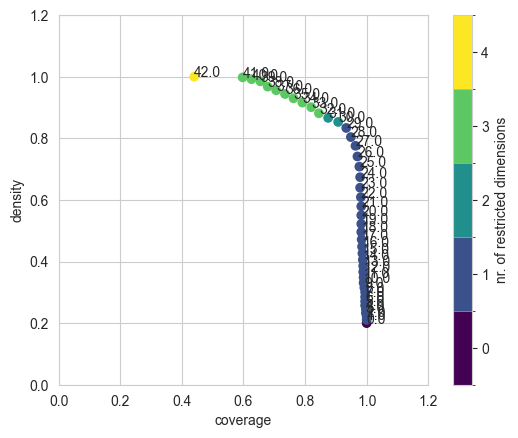

In [43]:
x = experiments.loc[:,:'discount rate 2']
PRIM_ijsel_damage_object, PRIM_ijsel_damage_box, y_ijsel_damage =  find_PRIM(x, outcomes, 'Expected Annual Damage', quantile = 0.8, threshold = 0.5, return_y = True)

PRIM_ijsel_deaths_object, PRIM_ijsel_deaths_box, y_ijsel_deaths =  find_PRIM(x, outcomes, 'Expected Number of Deaths', quantile = 0.8, threshold = 0.5, return_y = True)

[<Figure size 640x480 with 1 Axes>]

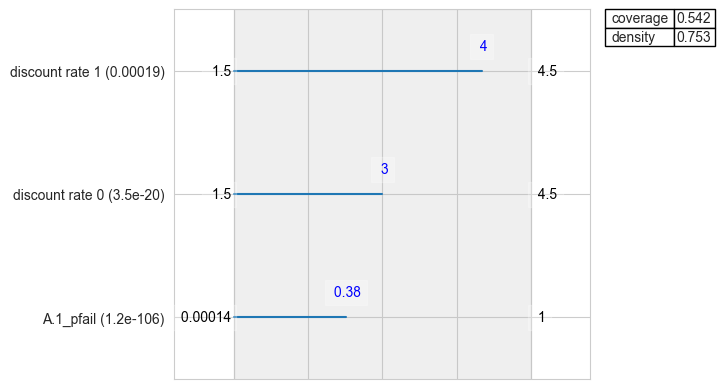

In [44]:
point = 22
PRIM_ijsel_damage_box.inspect(point, 'graph')

In [45]:
PRIM_ijsel_damage_box.resample(point)

[MainProcess/INFO] resample 0
[MainProcess/INFO] resample 1
[MainProcess/INFO] resample 2
[MainProcess/INFO] resample 3
[MainProcess/INFO] resample 4
[MainProcess/INFO] resample 5
[MainProcess/INFO] resample 6
[MainProcess/INFO] resample 7
[MainProcess/INFO] resample 8
[MainProcess/INFO] resample 9


reproduce coverage  reproduce density
A.1_pfail                             100.0              100.0
discount rate 1                        90.0               90.0
discount rate 0                        60.0               70.0
discount rate 2                        30.0               30.0
A.2_pfail                              20.0               20.0
A.0_ID flood wave shape                10.0               10.0
A.1_Bmax                               10.0               10.0
A.2_Bmax                               10.0               10.0
A.3_Bmax                               10.0               10.0
A.4_Bmax                               10.0               10.0
A.1_Brate                               0.0                0.0
A.2_Brate                               0.0                0.0
A.3_Brate                               0.0                0.0
A.3_pfail                               0.0                0.0
A.4_Brate                               0.0                0.0
A.4_pfail                               0.0                0.0
A.5_Bmax                                0.0                0.0
A.5_Brate                               0.0                0.0
A.5_pfail                               0.0                0.0

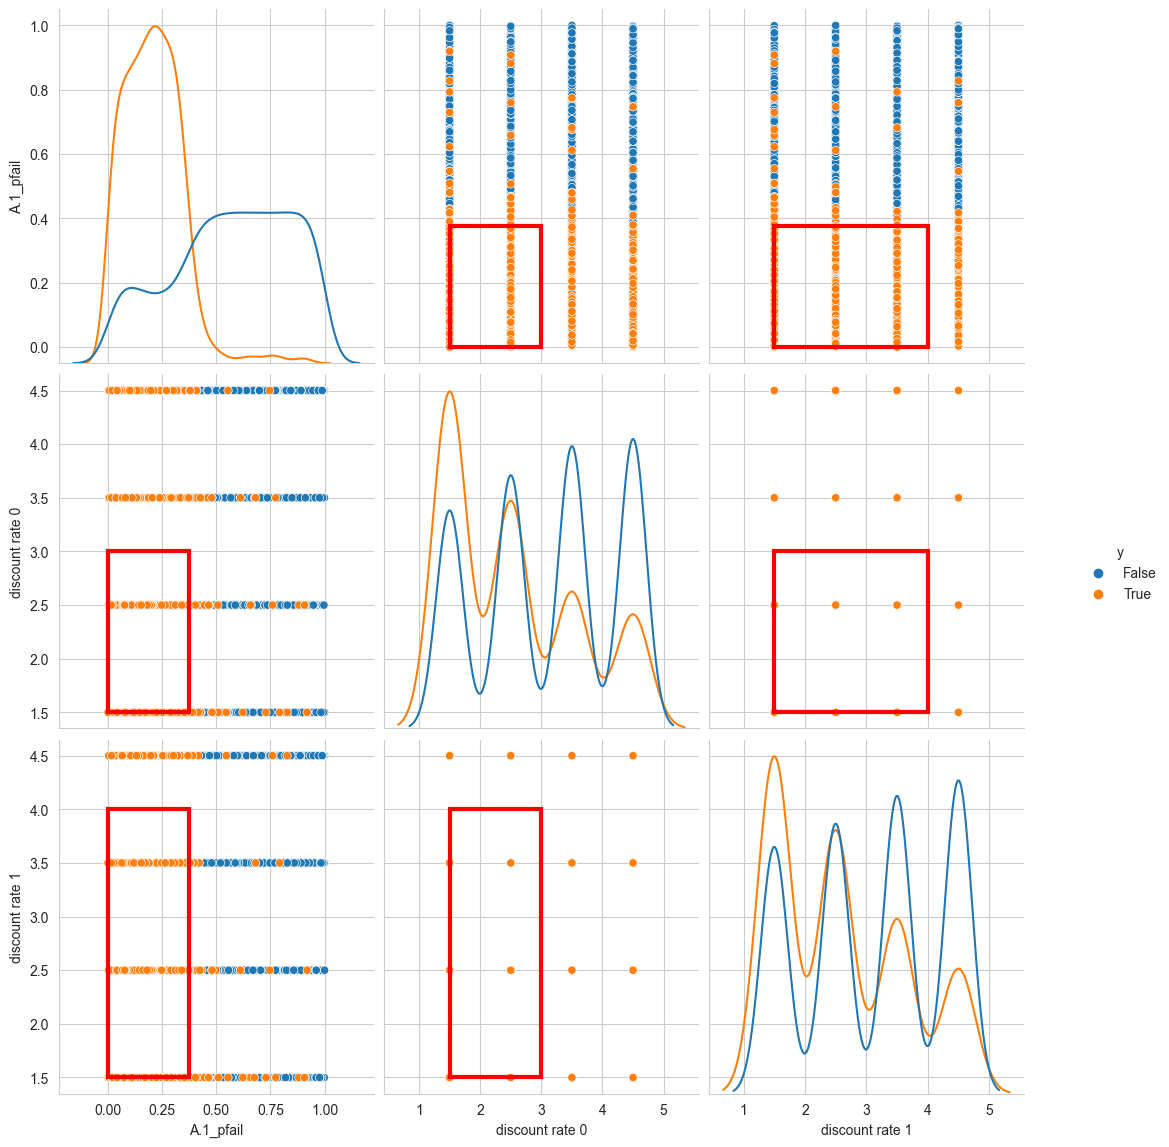

In [46]:
PRIM_ijsel_damage_box.select(point)
PRIM_ijsel_damage_box.show_pairs_scatter()
fig = plt.gcf()
fig.set_size_inches(12,12)
plt.grid()
plt.show()

### dimensional stacking

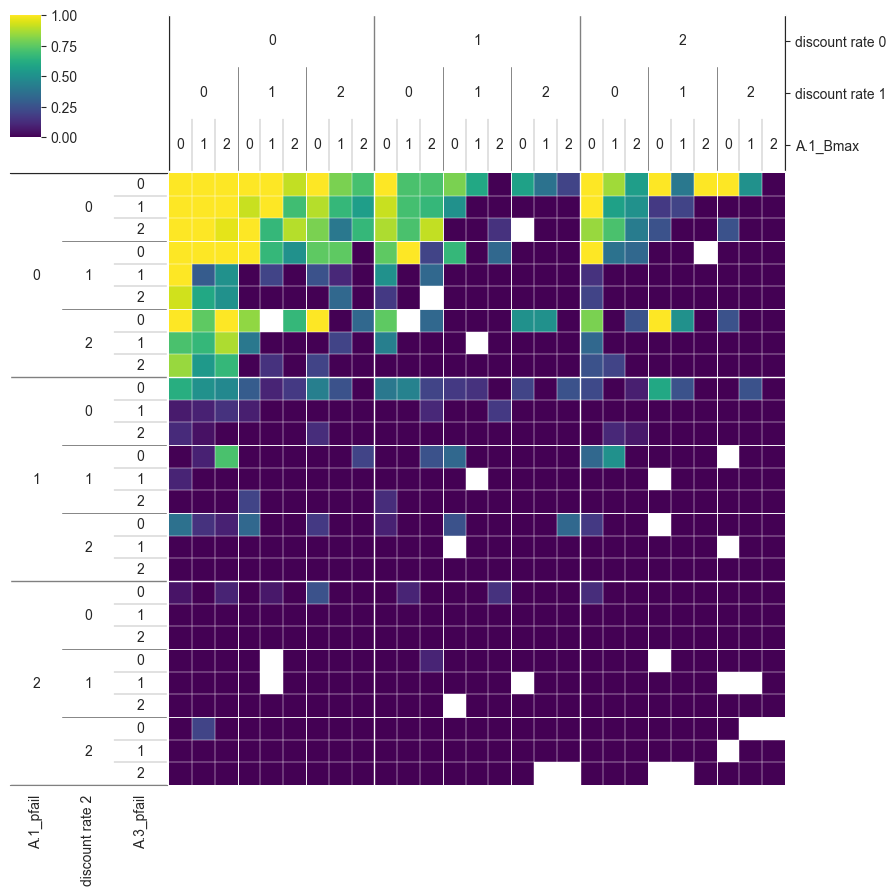

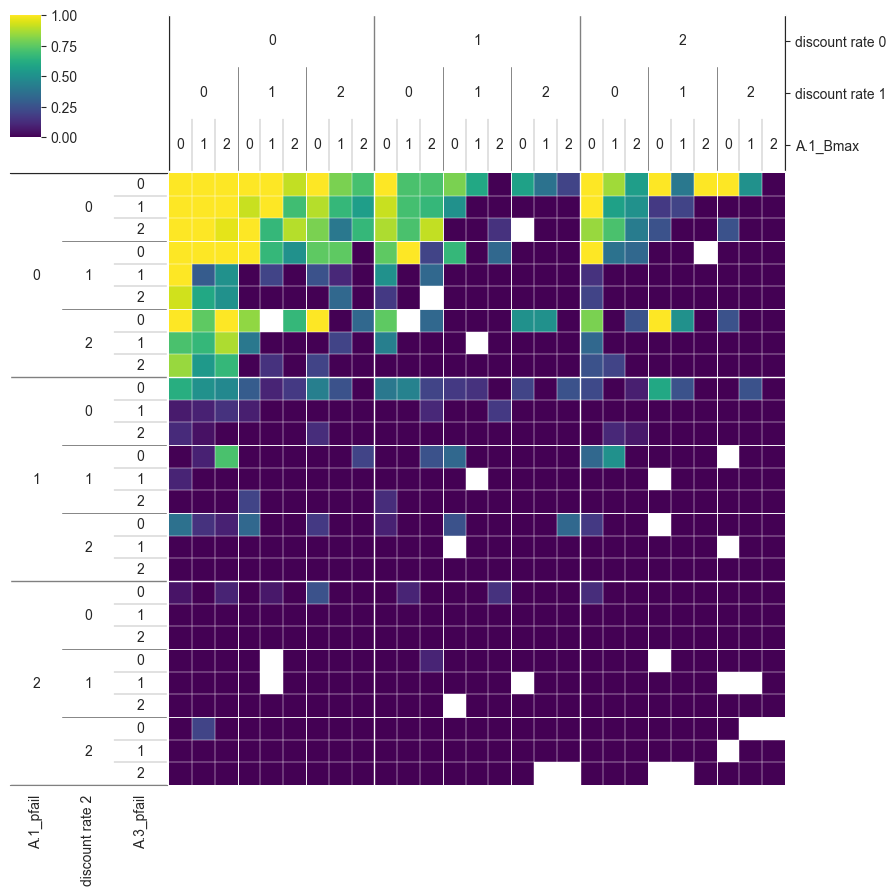

In [47]:
dimensional_stacking.create_pivot_plot(x, y_ijsel_damage)

## look into annual deaths

[MainProcess/INFO] 4000 points remaining, containing 800 cases of interest
[MainProcess/INFO] mean: 1.0, mass: 0.088, coverage: 0.44, density: 1.0 restricted_dimensions: 4


<Figure size 1500x1500 with 0 Axes>

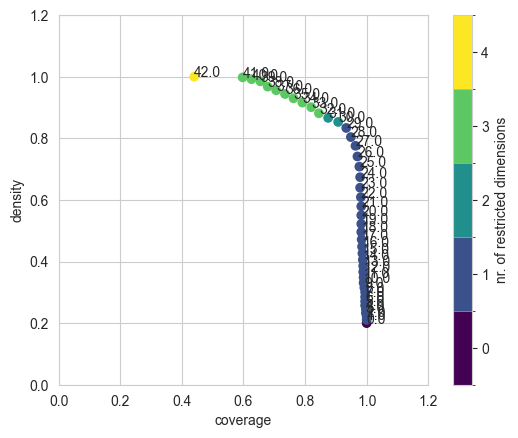

In [48]:
PRIM_ijsel_deaths_object, PRIM_ijsel_deaths_box, y_ijsel_deaths =  find_PRIM(x, outcomes, 'Expected Number of Deaths', quantile = 0.8, threshold = 0.5, return_y = True)


[<Figure size 640x480 with 1 Axes>]

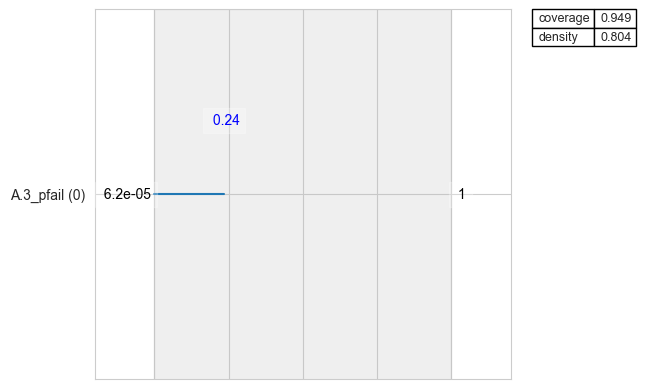

In [49]:
point = 28
PRIM_ijsel_deaths_box.inspect(point, 'graph')

In [50]:
PRIM_ijsel_deaths_box.resample(point)

[MainProcess/INFO] resample 0
[MainProcess/INFO] resample 1
[MainProcess/INFO] resample 2
[MainProcess/INFO] resample 3
[MainProcess/INFO] resample 4
[MainProcess/INFO] resample 5
[MainProcess/INFO] resample 6
[MainProcess/INFO] resample 7
[MainProcess/INFO] resample 8
[MainProcess/INFO] resample 9


reproduce coverage  reproduce density
A.3_pfail                             100.0              100.0
A.0_ID flood wave shape                 0.0                0.0
A.1_Bmax                                0.0                0.0
A.1_Brate                               0.0                0.0
A.1_pfail                               0.0                0.0
A.2_Bmax                                0.0                0.0
A.2_Brate                               0.0                0.0
A.2_pfail                               0.0                0.0
A.3_Bmax                                0.0                0.0
A.3_Brate                               0.0                0.0
A.4_Bmax                                0.0                0.0
A.4_Brate                               0.0                0.0
A.4_pfail                               0.0                0.0
A.5_Bmax                                0.0                0.0
A.5_Brate                               0.0                0.0
A.5_pfail                               0.0                0.0
discount rate 0                         0.0                0.0
discount rate 1                         0.0                0.0
discount rate 2                         0.0                0.0

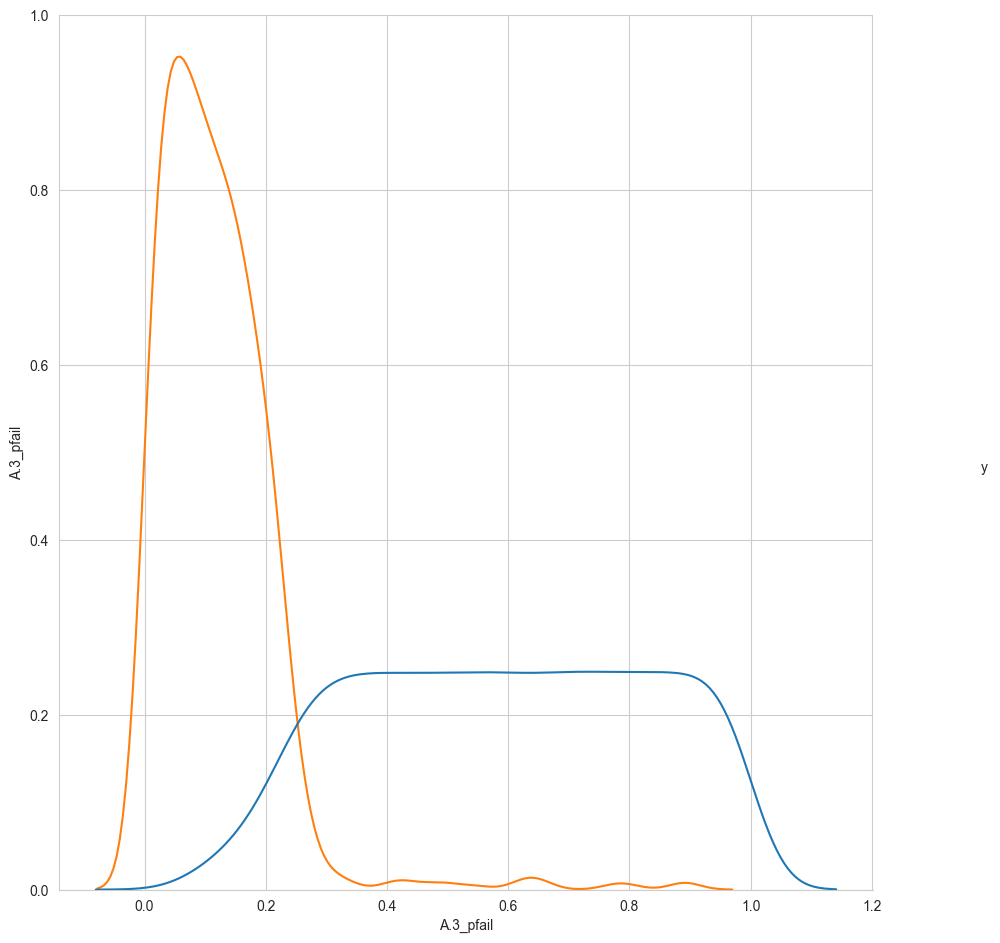

In [51]:
PRIM_ijsel_deaths_box.select(point)
PRIM_ijsel_deaths_box.show_pairs_scatter()
fig = plt.gcf()
fig.set_size_inches(12,12)
plt.show()

### dimensional stacking

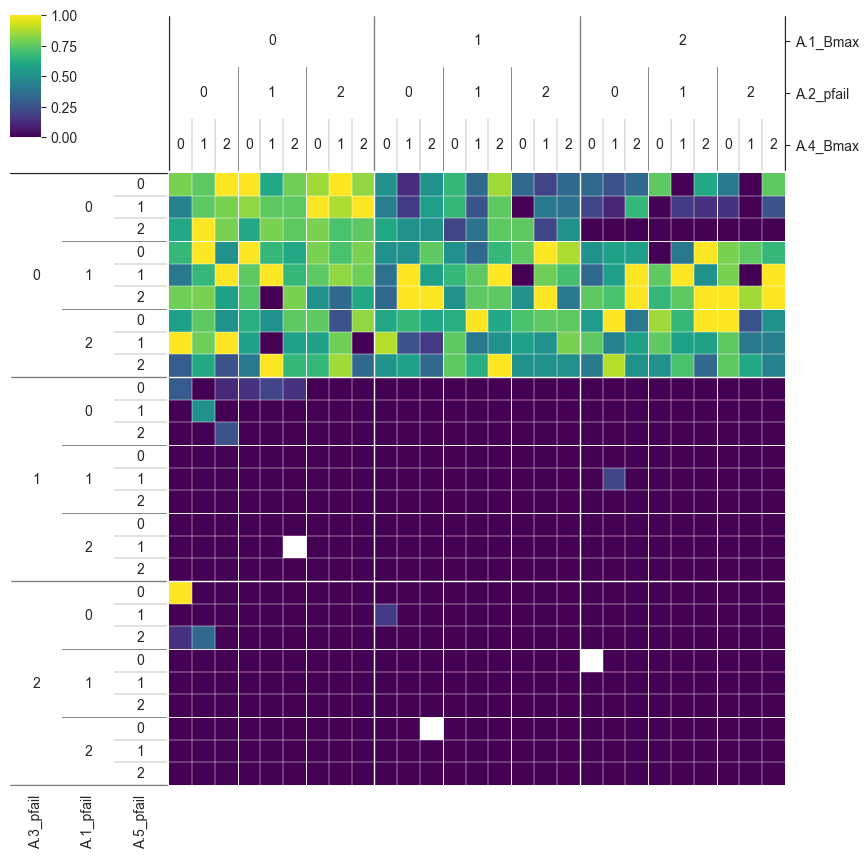

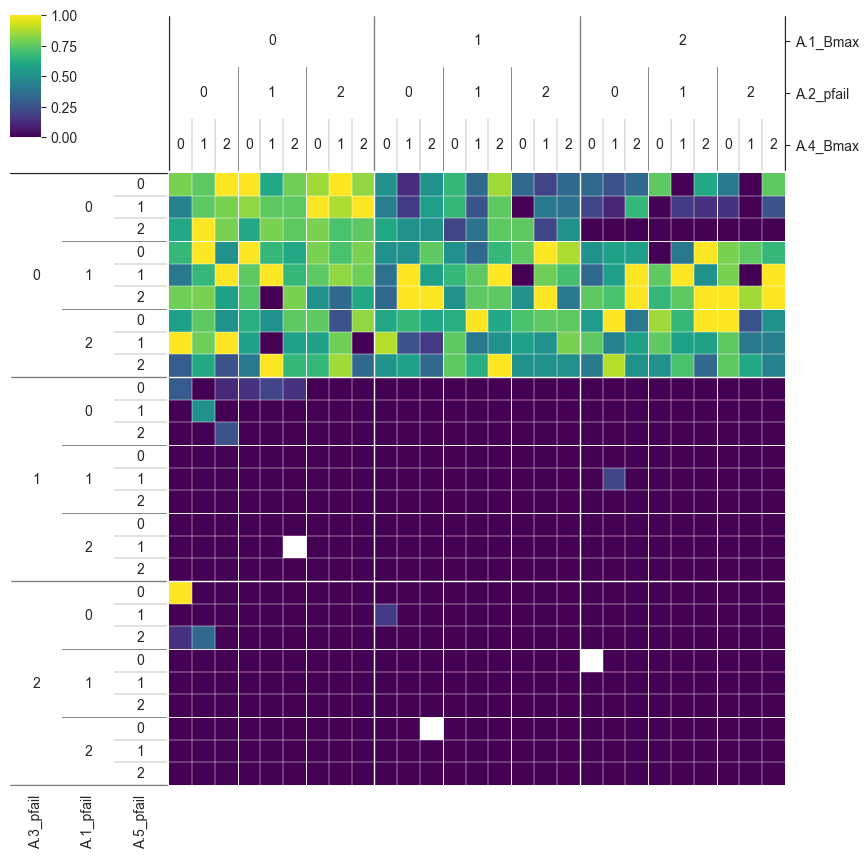

In [52]:
dimensional_stacking.create_pivot_plot(x, y_ijsel_deaths)

## look into comination of deaths and casualties

[MainProcess/INFO] 4000 points remaining, containing 1807 cases of interest
[MainProcess/INFO] mean: 0.9950617283950617, mass: 0.10125, coverage: 0.22302158273381295, density: 0.9950617283950617 restricted_dimensions: 9


<Figure size 1500x1500 with 0 Axes>

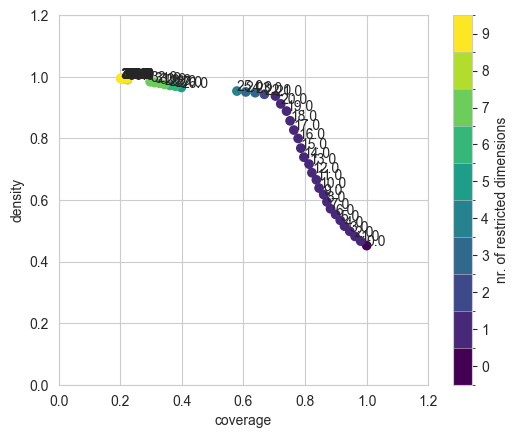

In [53]:
PRIM_ijsel_combined_object, PRIM_ijsel_combined_box, y_ijsel_combined  = find_PRIM(x, outcomes, ['Expected Number of Deaths','Expected Annual Damage'], quantile = 0.5, threshold = 0.5, return_y=True)

[<Figure size 640x480 with 1 Axes>]

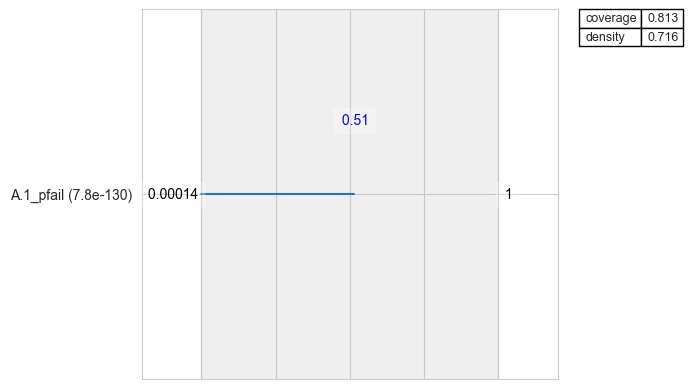

In [54]:
point = 13
PRIM_ijsel_combined_box.inspect(point, 'graph')

In [55]:
PRIM_ijsel_combined_box.resample(point)

[MainProcess/INFO] resample 0
[MainProcess/INFO] resample 1
[MainProcess/INFO] resample 2
[MainProcess/INFO] resample 3
[MainProcess/INFO] resample 4
[MainProcess/INFO] resample 5
[MainProcess/INFO] resample 6
[MainProcess/INFO] resample 7
[MainProcess/INFO] resample 8
[MainProcess/INFO] resample 9


reproduce coverage  reproduce density
A.1_pfail                             100.0              100.0
A.3_pfail                              10.0               10.0
A.0_ID flood wave shape                 0.0                0.0
A.1_Bmax                                0.0                0.0
A.1_Brate                               0.0                0.0
A.2_Bmax                                0.0                0.0
A.2_Brate                               0.0                0.0
A.2_pfail                               0.0                0.0
A.3_Bmax                                0.0                0.0
A.3_Brate                               0.0                0.0
A.4_Bmax                                0.0                0.0
A.4_Brate                               0.0                0.0
A.4_pfail                               0.0                0.0
A.5_Bmax                                0.0                0.0
A.5_Brate                               0.0                0.0
A.5_pfail                               0.0                0.0
discount rate 0                         0.0                0.0
discount rate 1                         0.0                0.0
discount rate 2                         0.0                0.0

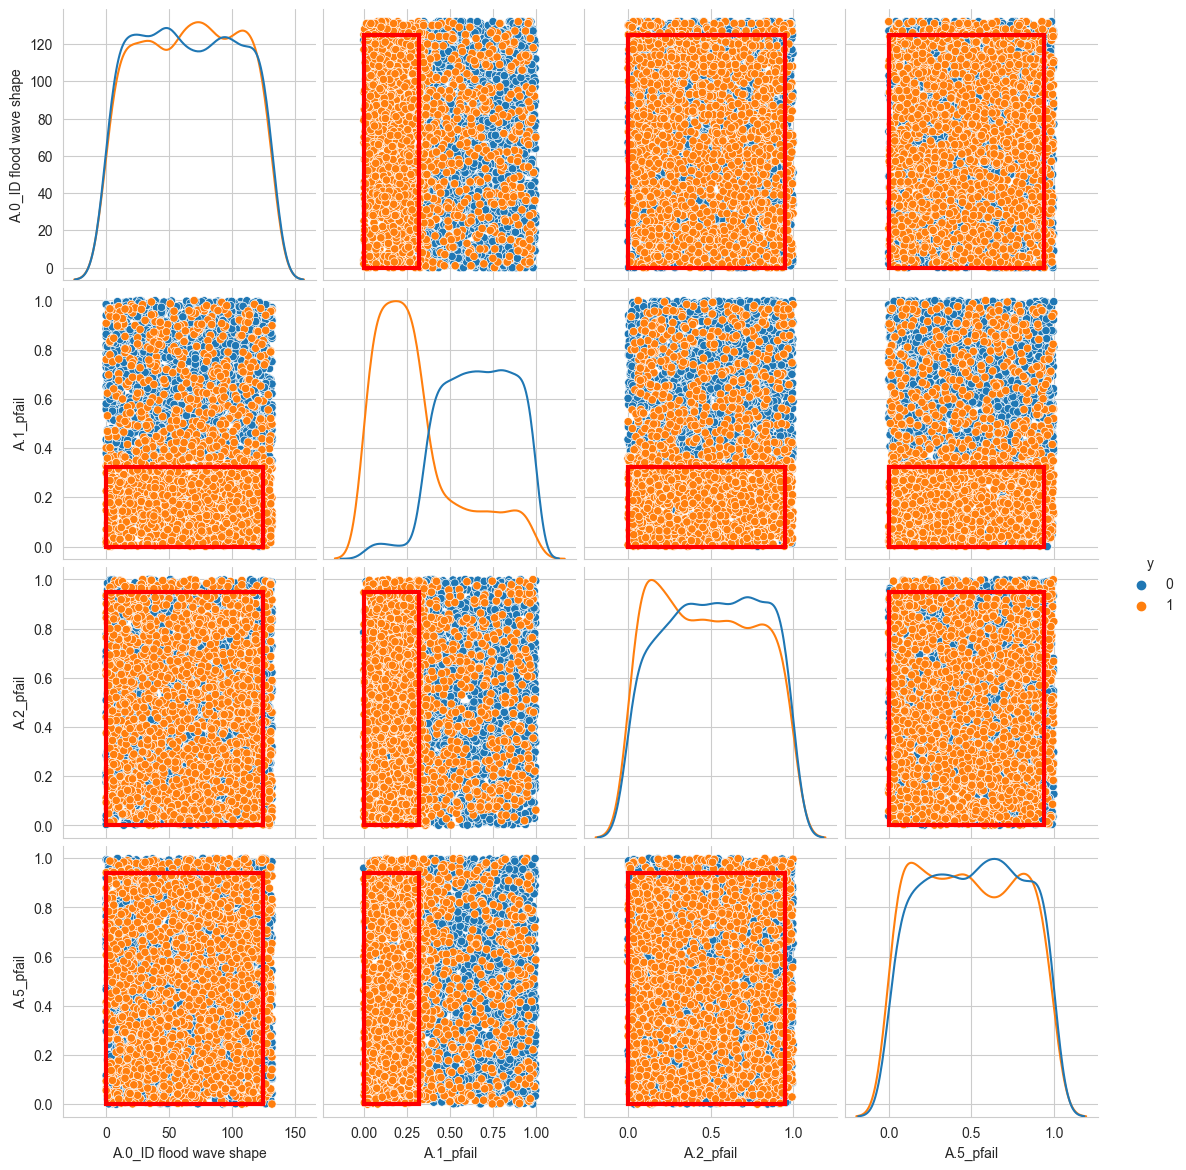

In [69]:
PRIM_ijsel_combined_box.select(point)
PRIM_ijsel_combined_box.show_pairs_scatter()
fig = plt.gcf()
fig.set_size_inches(12,12)
plt.show()

### dimensional stacking

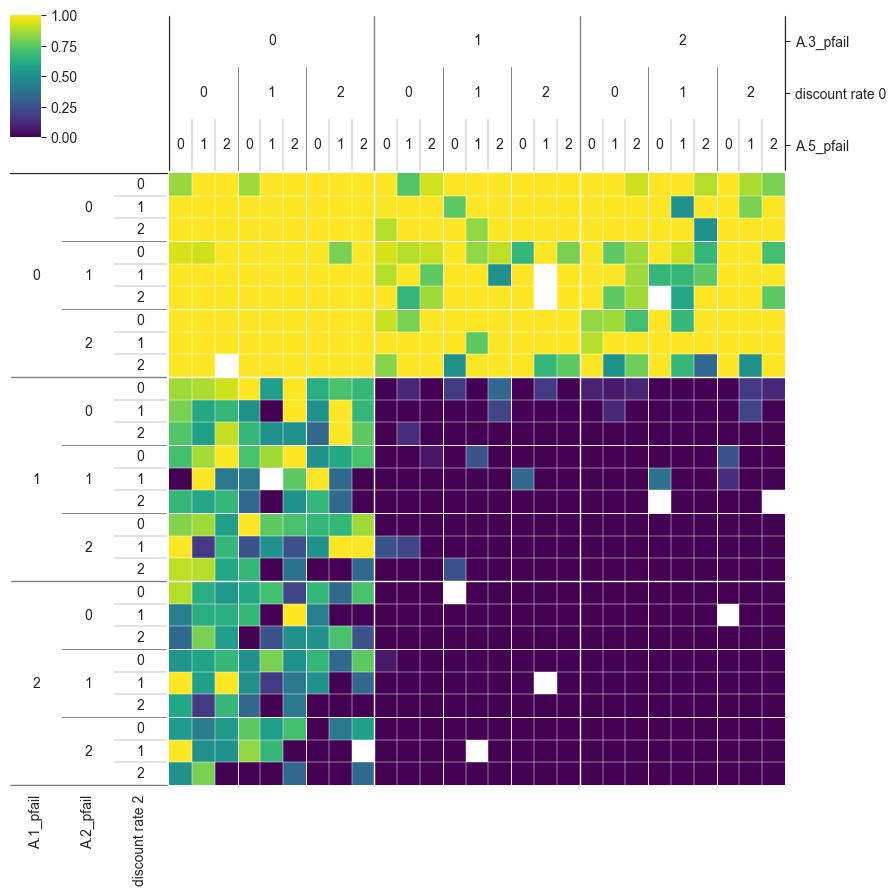

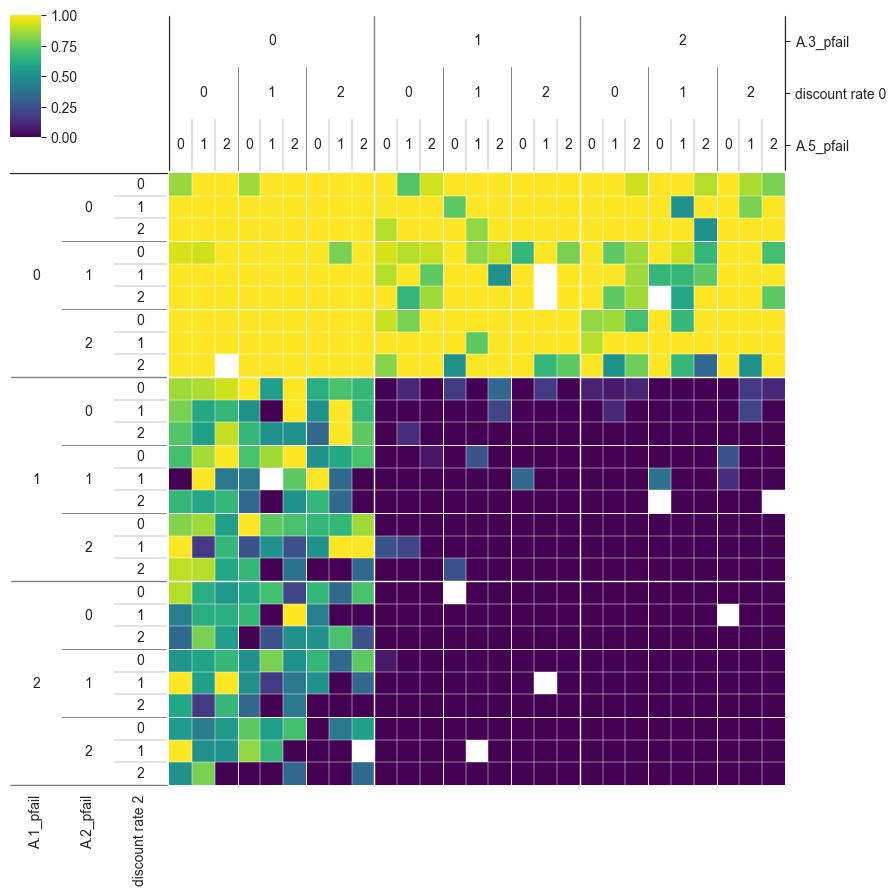

In [57]:
dimensional_stacking.create_pivot_plot(x, y_ijsel_combined)

### Overijssel area

### import the model PF3

In [58]:
# Load results that were previously generated
load_file_name ='results/4000  base scenarios policy pf 3.tar.gz'
experiments, outcomes = load_results(load_file_name)

[MainProcess/INFO] results loaded successfully from C:\Users\Shahram\PyCharm\final assignment_MBDM2_Frenk\final assignment\results\4000  base scenarios policy pf 3.tar.gz


In [59]:
# experiments, outcomes = results
print(outcomes.keys())
display(experiments)


dict_keys(['A.1 Total Costs', 'A.1_Expected Number of Deaths', 'A.2 Total Costs', 'A.2_Expected Number of Deaths', 'A.3 Total Costs', 'A.3_Expected Number of Deaths', 'A.4 Total Costs', 'A.4_Expected Number of Deaths', 'A.5 Total Costs', 'A.5_Expected Number of Deaths', 'RfR Total Costs', 'Expected Evacuation Costs'])


A.0_ID flood wave shape    A.1_Bmax  A.1_Brate  A.1_pfail    A.2_Bmax   
0                          31  218.416910        1.5   0.758529  249.380665  \
1                         119   33.578084        1.5   0.969431  250.076413   
2                          10  291.684050        1.0   0.771114  144.855169   
3                          49  133.104980        1.0   0.384650   69.526427   
4                           3  286.098693       10.0   0.078982  193.135959   
...                       ...         ...        ...        ...         ...   
3995                      121  251.814686        1.5   0.841451  313.333153   
3996                      104   96.680122        1.5   0.402793  315.524262   
3997                      107  326.855770       10.0   0.155556  325.329399   
3998                       98  211.456298       10.0   0.243812  325.479483   
3999                       13   30.722863        1.5   0.821601  310.174069   

      A.2_Brate  A.2_pfail    A.3_Bmax  A.3_Brate  A.3_pfail  ...   
0           1.0   0.579663   76.455316        1.5   0.015850  ...  \
1           1.0   0.905285  261.754102        1.0   0.606421  ...   
2           1.0   0.463173  106.911678        1.0   0.163265  ...   
3           1.5   0.914441  279.666357       10.0   0.530577  ...   
4           1.0   0.893144   47.182791        1.5   0.543908  ...   
...         ...        ...         ...        ...        ...  ...   
3995       10.0   0.733286  182.568829        1.0   0.564667  ...   
3996        1.0   0.033865  133.084429        1.5   0.503735  ...   
3997        1.0   0.215002  201.318521        1.5   0.611371  ...   
3998       10.0   0.950388  211.230196       10.0   0.197271  ...   
3999        1.0   0.151283  135.031025        1.0   0.791605  ...   

      A.3_DikeIncrease 2  A.4_DikeIncrease 0  A.4_DikeIncrease 1   
0                      0                   0                   0  \
1                      0                   0                   0   
2                      0                   0                   0   
3                      0                   0                   0   
4                      0                   0                   0   
...                  ...                 ...                 ...   
3995                   0                   0                   0   
3996                   0                   0                   0   
3997                   0                   0                   0   
3998                   0                   0                   0   
3999                   0                   0                   0   

      A.4_DikeIncrease 2  A.5_DikeIncrease 0  A.5_DikeIncrease 1   
0                      0                   0                   0  \
1                      0                   0                   0   
2                      0                   0                   0   
3                      0                   0                   0   
4                      0                   0                   0   
...                  ...                 ...                 ...   
3995                   0                   0                   0   
3996                   0                   0                   0   
3997                   0                   0                   0   
3998                   0                   0                   0   
3999                   0                   0                   0   

      A.5_DikeIncrease 2  scenario    policy     model  
0                      0         0  policy 1  dikesnet  
1                      0         1  policy 1  dikesnet  
2                      0         2  policy 1  dikesnet  
3                      0         3  policy 1  dikesnet  
4                      0         4  policy 1  dikesnet  
...                  ...       ...       ...       ...  
3995                   0      3995  policy 1  dikesnet  
3996                   0      3996  policy 1  dikesnet  
3997                   0      3997  policy 1  dikesnet  
3998                   0

### combine dike ring 4 and 5

In [60]:
# outcome_names_overijssel = outcome_names_ring_4 + outcome_names_ring_5
cost_ring_4 = outcomes['A.4 Total Costs']
cost_ring_5 = outcomes['A.5 Total Costs']
fatalities_ring_4 = outcomes['A.4_Expected Number of Deaths']
fatalities_ring_5 = outcomes['A.5_Expected Number of Deaths']


outcomes['overijssel Total Costs'] = cost_ring_4 + cost_ring_5
outcomes['overijssel_Expected Number of Deaths'] = fatalities_ring_4 + fatalities_ring_5

# print(cost_ring_4[5] + cost_ring_5[5])
# print(cost_overijssel[5])


experiments_ring_4 = experiments.loc[:, 'A.4_Bmax':'A.4_pfail']
experiments_ring_5 = experiments.loc[:, 'A.5_Bmax':'A.5_pfail']
experiments_overijssel = experiments.loc[:, 'A.4_Bmax':'A.5_pfail']

### Look into annual deaths

[MainProcess/INFO] 4000 points remaining, containing 800 cases of interest
[MainProcess/INFO] mean: 0.7033492822966507, mass: 0.05225, coverage: 0.18375, density: 0.7033492822966507 restricted_dimensions: 4


<Figure size 1500x1500 with 0 Axes>

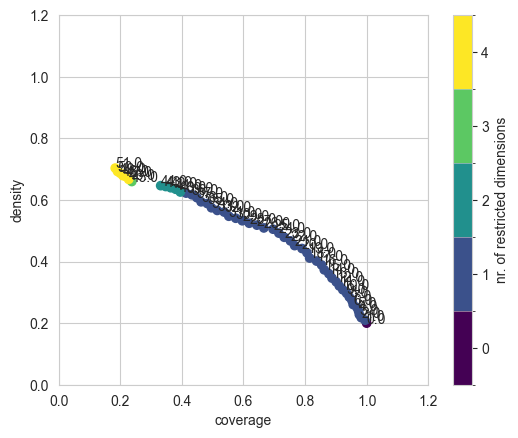

In [61]:
PRIM_overijssel_deaths_object, PRIM_overijssel_deaths_box =  find_PRIM(experiments_overijssel, outcomes, 'overijssel_Expected Number of Deaths', quantile = 0.8, threshold = 0.5)

[<Figure size 640x480 with 1 Axes>]

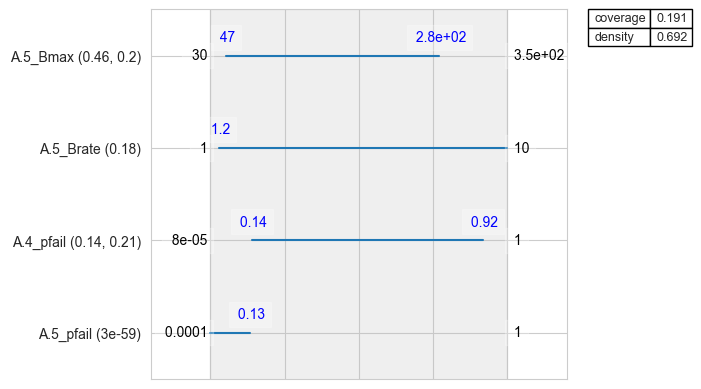

In [62]:
point = 50
PRIM_overijssel_deaths_box.inspect(point, 'graph')

In [63]:
PRIM_overijssel_deaths_box.resample(point)

[MainProcess/INFO] resample 0
[MainProcess/INFO] resample 1
[MainProcess/INFO] resample 2
[MainProcess/INFO] resample 3
[MainProcess/INFO] resample 4
[MainProcess/INFO] resample 5
[MainProcess/INFO] resample 6
[MainProcess/INFO] resample 7
[MainProcess/INFO] resample 8
[MainProcess/INFO] resample 9


reproduce coverage  reproduce density
A.5_pfail               100.0              100.0
A.4_pfail                90.0               70.0
A.4_Bmax                 80.0               90.0
A.5_Brate                80.0               80.0
A.5_Bmax                 50.0               60.0
A.4_Brate                10.0               10.0

### Look into cost

[MainProcess/INFO] 4000 points remaining, containing 800 cases of interest
[MainProcess/INFO] mean: 0.7451923076923077, mass: 0.052, coverage: 0.19375, density: 0.7451923076923077 restricted_dimensions: 3


<Figure size 1500x1500 with 0 Axes>

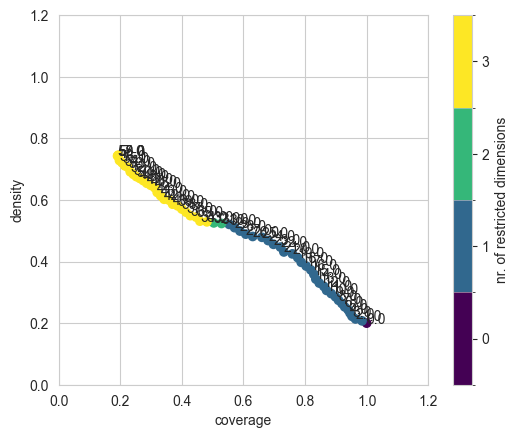

In [64]:
PRIM_overijssel_costs_object, PRIM_overijssel_costs_box =  find_PRIM(experiments_overijssel, outcomes, 'overijssel Total Costs', quantile = 0.8, threshold = 0.5)

[<Figure size 640x480 with 1 Axes>]

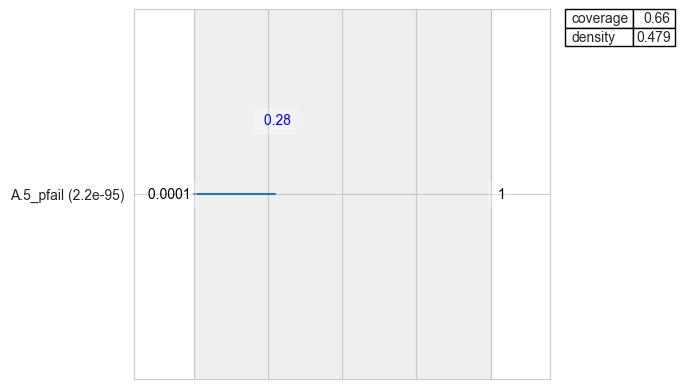

In [65]:
point = 25
PRIM_overijssel_costs_box.inspect(point, 'graph')

In [66]:
PRIM_overijssel_costs_box.resample(point)

[MainProcess/INFO] resample 0
[MainProcess/INFO] resample 1
[MainProcess/INFO] resample 2
[MainProcess/INFO] resample 3
[MainProcess/INFO] resample 4
[MainProcess/INFO] resample 5
[MainProcess/INFO] resample 6
[MainProcess/INFO] resample 7
[MainProcess/INFO] resample 8
[MainProcess/INFO] resample 9


reproduce coverage  reproduce density
A.5_pfail               100.0              100.0
A.4_Bmax                  0.0               20.0
A.5_Bmax                  0.0               10.0
A.5_Brate                 0.0               10.0
A.4_Brate                 0.0                0.0
A.4_pfail                 0.0                0.0

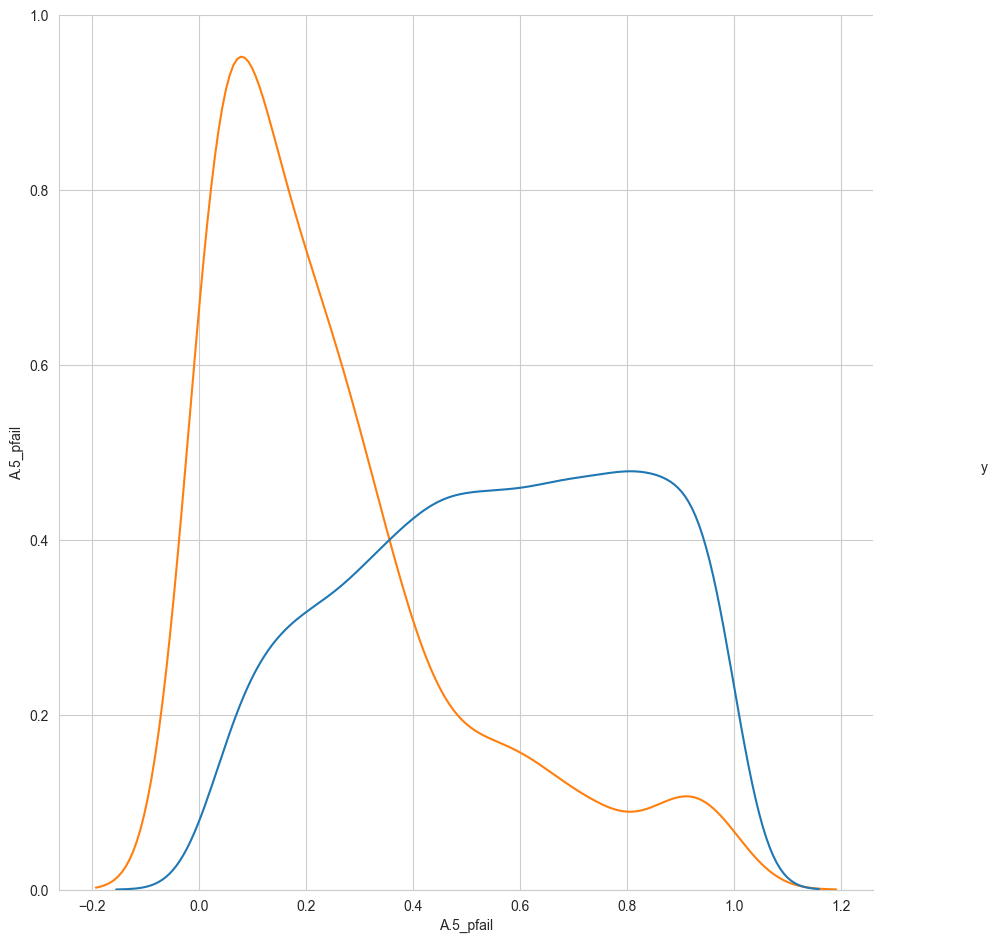

In [70]:
PRIM_overijssel_costs_box.select(point)
PRIM_overijssel_costs_box.show_pairs_scatter()
fig = plt.gcf()
fig.set_size_inches(12,12)
plt.show()

## look into costs and deaths combined

[MainProcess/INFO] 4000 points remaining, containing 927 cases of interest
[MainProcess/INFO] mean: 0.730593607305936, mass: 0.05475, coverage: 0.1725997842502697, density: 0.730593607305936 restricted_dimensions: 4


<Figure size 1500x1500 with 0 Axes>

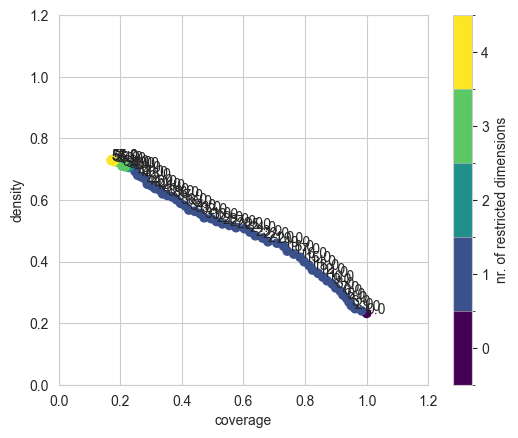

In [68]:
PRIM_overijssel_combined_object, PRIM_overijssel_combined_box =  find_PRIM(experiments_overijssel, outcomes, ['overijssel Total Costs','overijssel_Expected Number of Deaths'] , quantile = 0.75, threshold = 0.5)

[<Figure size 640x480 with 1 Axes>]

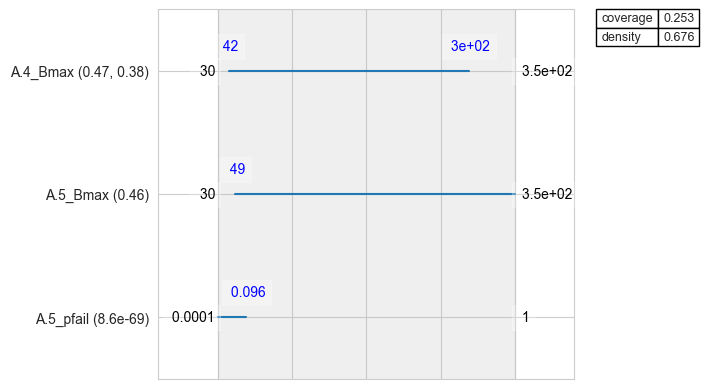

In [71]:
point = 50
PRIM_overijssel_costs_box.inspect(point, 'graph')

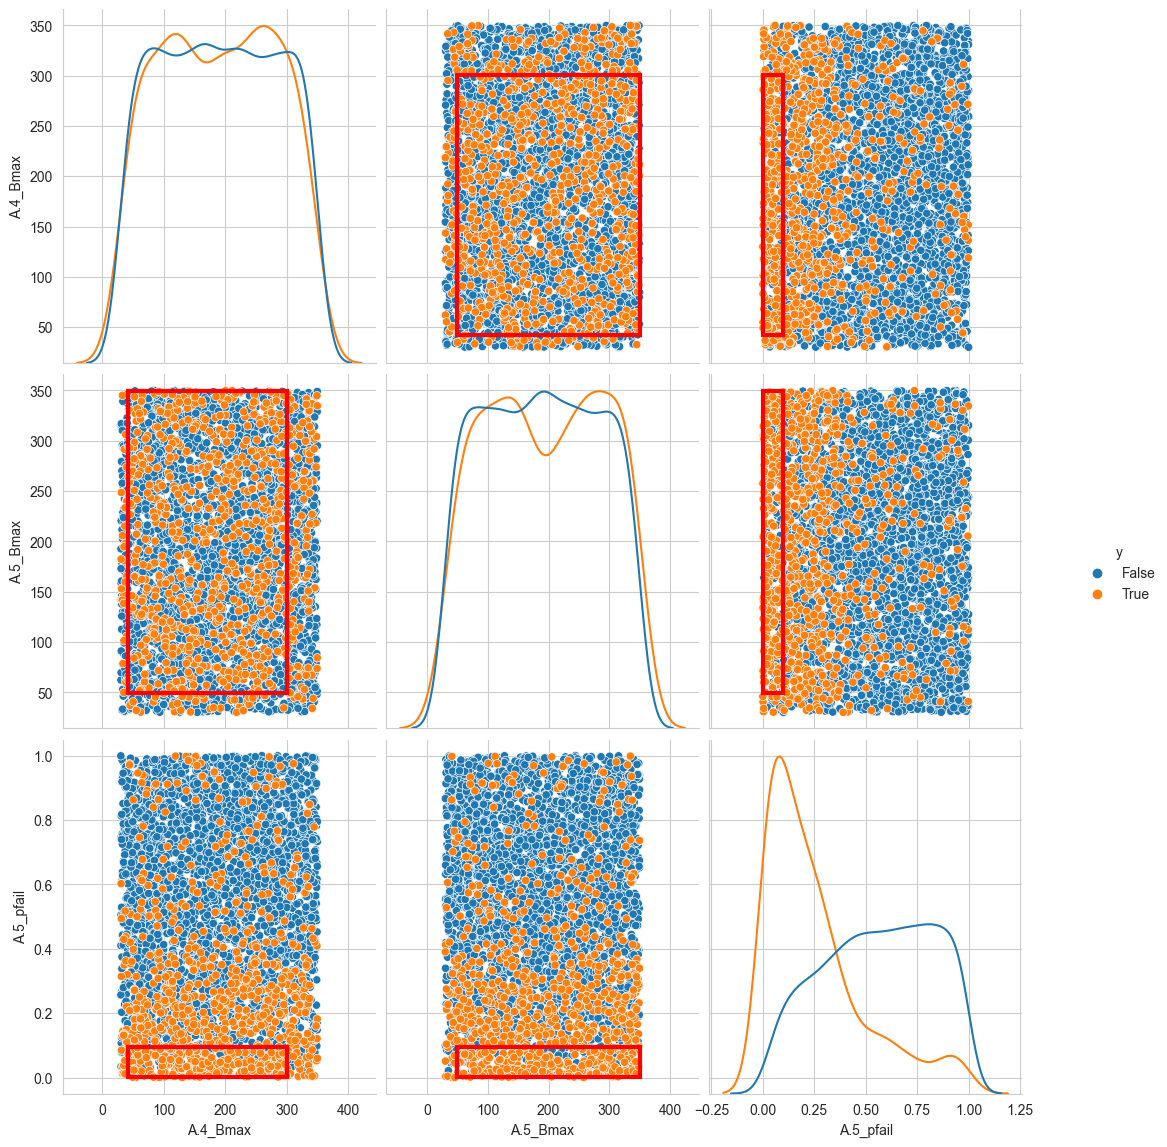

In [72]:
PRIM_overijssel_costs_box.select(point)
PRIM_overijssel_costs_box.show_pairs_scatter()
fig = plt.gcf()
fig.set_size_inches(12,12)
plt.show()